AIM: Segment users into behavioral groups such as loyal learners, dormant accounts, passive observers through clustering techniques like K-means, DBSCAN or hierarchical clustering


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv("ECLearnix.csv")

In [3]:
selected_columns = [
    'User_Type', 'Region', 'Department', 'Platform_Source',
    'App_Installed', 'First_Login_Completed', 'Registered_for_Event',
    'Course_Completed', 'Newsletter_Subscribed',
    'Time_Spent_Total_Minutes', 'Days_Since_Last_Activity'
]

df_clustering = df[selected_columns].copy()

In [4]:
categorical_cols = ['User_Type', 'Region', 'Department', 'Platform_Source']
numerical_cols = [
    'App_Installed', 'First_Login_Completed', 'Registered_for_Event',
    'Course_Completed', 'Newsletter_Subscribed',
    'Time_Spent_Total_Minutes', 'Days_Since_Last_Activity'
]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(df_clustering)


In [5]:
print("Processed shape:", X_processed.shape)


Processed shape: (10000, 25)


10000 rows and 25 total columns


In [6]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from sklearn.preprocessing import StandardScaler

In [8]:
ohe_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(ohe_features) + numerical_cols

# Create a DataFrame from the processed array
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)

# Inspect
print(X_processed_df.head())
print(X_processed_df.shape)

   User_Type_Faculty  User_Type_Professional  User_Type_Student  Region_East  \
0                1.0                     0.0                0.0          0.0   
1                1.0                     0.0                0.0          0.0   
2                1.0                     0.0                0.0          0.0   
3                0.0                     1.0                0.0          0.0   
4                1.0                     0.0                0.0          1.0   

   Region_North  Region_South  Region_West  Department_Commerce  \
0           0.0           1.0          0.0                  0.0   
1           0.0           0.0          1.0                  0.0   
2           1.0           0.0          0.0                  0.0   
3           0.0           1.0          0.0                  0.0   
4           0.0           0.0          0.0                  0.0   

   Department_Engineering  Department_Law  ...  Platform_Source_LinkedIn  \
0                     0.0             0.

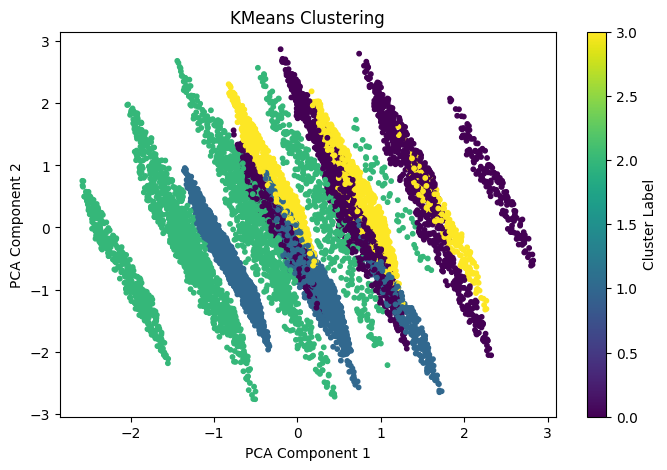

In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_processed_df)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed_df)

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title("KMeans Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.show()


In [14]:
df_clustering['Cluster_KMeans'] = kmeans_labels

In [15]:
# Group by cluster to understand behavioral patterns
cluster_summary = df_clustering.groupby('Cluster_KMeans')[
    ['App_Installed', 'First_Login_Completed', 'Registered_for_Event',
     'Course_Completed', 'Newsletter_Subscribed', 'Time_Spent_Total_Minutes',
     'Days_Since_Last_Activity']
].mean().round(2)

print(cluster_summary)


                App_Installed  First_Login_Completed  Registered_for_Event  \
Cluster_KMeans                                                               
0                         1.0                   0.00                  0.50   
1                         1.0                   1.00                  0.49   
2                         0.0                   0.62                  0.49   
3                         1.0                   1.00                  0.51   

                Course_Completed  Newsletter_Subscribed  \
Cluster_KMeans                                            
0                           0.42                   0.26   
1                           0.00                   0.26   
2                           0.39                   0.25   
3                           1.00                   0.26   

                Time_Spent_Total_Minutes  Days_Since_Last_Activity  
Cluster_KMeans                                                      
0                                 257.

| Cluster | Key Traits                                                                                                                                                 | Likely Behavior Segment                                                                                                                          |
| ------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------ |
| **0**   | ✅ App installed<br>❌ Login not completed<br>Medium time spent (257 min)<br>🟡 Partial course completion (0.42)<br>📅 High days since last activity (44.98) | **Observer / Unconverted**<br>These users installed the app but never logged in, suggesting interest but no engagement.                          |
| **1**   | ✅ App installed<br>✅ Login completed<br>❌ No courses completed<br>📅 High inactivity (44.95 days)<br>⏱ Medium time spent                                   | **Dormant Users**<br>These were active at some point but dropped off. They logged in, but didn’t complete content. Could be re-targeted.         |
| **2**   | ❌ App not installed<br>🟡 Partial login<br>🟡 Partial course completion<br>📅 43.83 days since activity                                                    | **Web-Only Users**<br>Likely accessed content without app use. They’re mid-level users, may not be very engaged.                                 |
| **3**   | ✅ App installed<br>✅ Login completed<br>✅ Full course completion (1.0)<br>⏱ 252 mins spent<br>📅 High inactivity (44.75)                                   | **Loyal but Recently Inactive**<br>These users were fully engaged and completed content. Now inactive — they’re high-value but may need a nudge. |


In [16]:
cluster_labels = {
    0: 'Observer',
    1: 'Dormant User',
    2: 'Partial Web User',
    3: 'Loyal but Inactive'
}
df_clustering['Behavior_Segment'] = df_clustering['Cluster_KMeans'].map(cluster_labels)


In [17]:
print(df_clustering['Cluster_KMeans'].value_counts())


Cluster_KMeans
2    3031
0    2798
1    2484
3    1687
Name: count, dtype: int64


| Cluster ID | Segment Label         | Count | % of Users | Interpretation                                                                     |
| ---------- | --------------------- | ----- | ---------- | ---------------------------------------------------------------------------------- |
| **2**      | 🔵 Partial Web Users  | 3031  | **30.3%**  | Largest group; moderate engagement but no app usage. They browse, maybe undecided. |
| **0**      | 🟡 Observers          | 2798  | **27.9%**  | Installed but didn’t log in. Interested, but lost. Re-engagement needed.           |
| **1**      | 🔴 Dormant Users      | 2484  | **24.8%**  | Logged in but didn’t complete courses. Dropped off. Push them toward value.        |
| **3**      | 🟢 Loyal but Inactive | 1687  | **16.9%**  | Best users (high completion) but inactive now. High priority to re-engage.         |


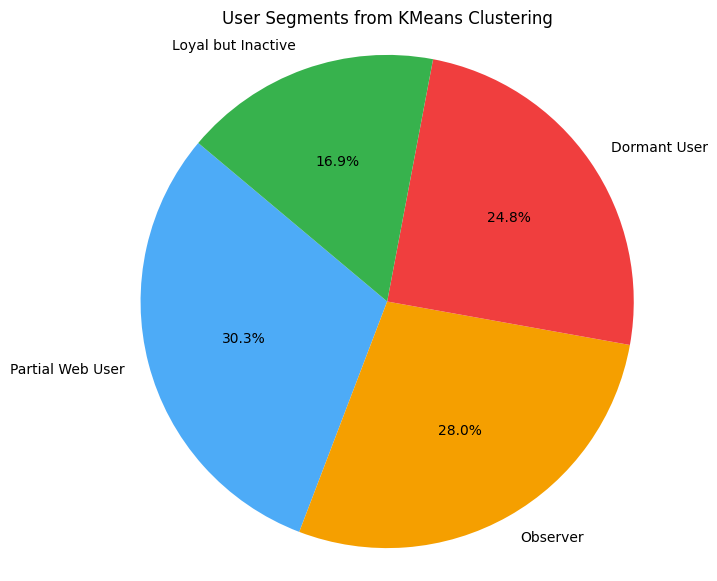

In [18]:
import matplotlib.pyplot as plt

segment_counts = df_clustering['Behavior_Segment'].value_counts()
colors = ['#4dabf7', '#f59f00', '#f03e3e', '#37b24d']  # blue, yellow, red, green

plt.figure(figsize=(7, 7))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('User Segments from KMeans Clustering')
plt.axis('equal')
plt.show()


In [19]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Apply DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_processed)

# Attach to dataframe
df_clustering['Cluster_DBSCAN'] = dbscan_labels

# Evaluate (ignoring noise points labeled -1)
if len(set(dbscan_labels)) > 1:
    score_dbscan = silhouette_score(X_processed[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print("Silhouette Score (DBSCAN):", round(score_dbscan, 4))
else:
    print("DBSCAN formed only one cluster or mostly noise.")



DBSCAN formed only one cluster or mostly noise.


Failed Clustering through DBSCAN!

DBSCAN failing is a very common and informative outcome as dataset consists:


*   Users vary gradually rather than forming tight density-based groups
*   Features are scaled, but not spatially clustered

helps confirm that KMeans (or even Agglomerative Clustering) is more suited for behavioral segmentation in this use case


In [22]:
from sklearn.cluster import AgglomerativeClustering

# Try with 4 clusters (as seen effective in KMeans)
agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(X_processed)

# Attach to dataframe
df_clustering['Cluster_Agglo'] = agglo_labels

# Evaluate
score_agglo = silhouette_score(X_processed, agglo_labels)
print("Silhouette Score (Agglomerative):", round(score_agglo, 4))


Silhouette Score (Agglomerative): 0.1037


| Score Range   | Meaning                              |
| ------------- | ------------------------------------ |
| **> 0.7**     | Strong, well-separated clusters      |
| **0.4 – 0.7** | Decent clusters, some overlap        |
| **0.1 – 0.4** | Weak clustering structure            |
| **< 0.1**     | Likely noisy or overlapping clusters |


In [23]:
print("KMeans Clusters:")
print(df_clustering['Cluster_KMeans'].value_counts())

print("\nDBSCAN Clusters (including -1 = noise):")
print(df_clustering['Cluster_DBSCAN'].value_counts())

print("\nAgglomerative Clusters:")
print(df_clustering['Cluster_Agglo'].value_counts())


KMeans Clusters:
Cluster_KMeans
2    3031
0    2798
1    2484
3    1687
Name: count, dtype: int64

DBSCAN Clusters (including -1 = noise):
Cluster_DBSCAN
-1    10000
Name: count, dtype: int64

Agglomerative Clusters:
Cluster_Agglo
0    3092
1    2545
2    2288
3    2075
Name: count, dtype: int64


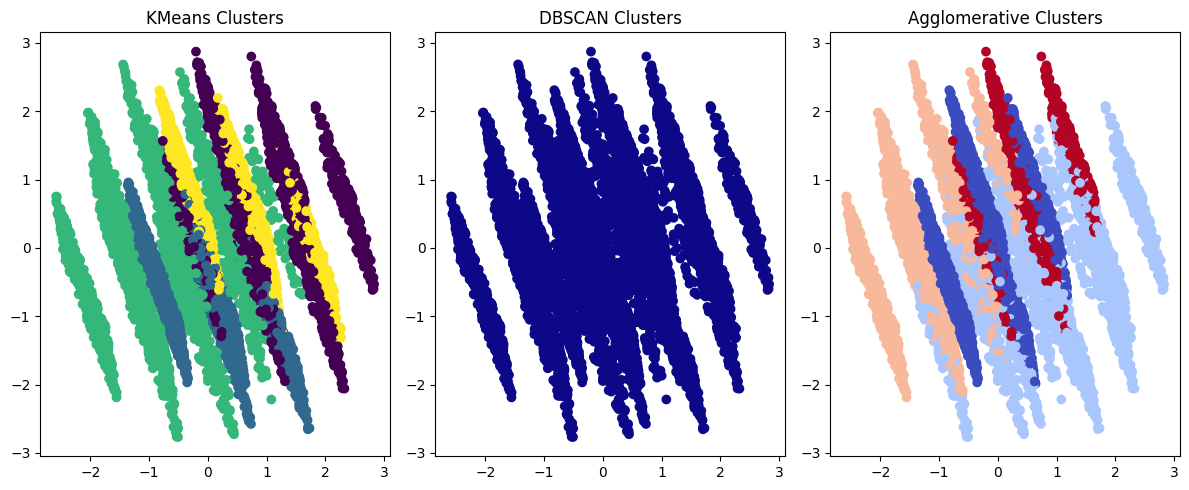

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(12, 5))

# KMeans
plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_clustering['Cluster_KMeans'], cmap='viridis')
plt.title('KMeans Clusters')

# DBSCAN
plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_clustering['Cluster_DBSCAN'], cmap='plasma')
plt.title('DBSCAN Clusters')

# Agglomerative
plt.subplot(1, 3, 3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_clustering['Cluster_Agglo'], cmap='coolwarm')
plt.title('Agglomerative Clusters')

plt.tight_layout()
plt.show()


🔹 KMeans Clustering

Cluster 2: 3031 users  
Cluster 0: 2798 users  
Cluster 1: 2484 users  
Cluster 3: 1687 users

KMeans found 4 clusters with relatively
balanced distribution.

These clusters likely reflect different engagement types (e.g., explorers, loyal users, inactive observers).

The best-performing clustering (based on interpretability + balance).



🔸 DBSCAN Clustering

Cluster -1: 10000 users (all marked as
noise)

DBSCAN failed to detect valid clusters — it treated all users as outliers/noise.

Likely due to high dimensionality or dense feature space where DBSCAN's distance thresholds don’t work well.


🔹 Agglomerative Clustering

Cluster 0: 3092  
Cluster 1: 2545  
Cluster 2: 2288  
Cluster 3: 2075

Also found 4 clusters, reasonably balanced.

Silhouette score was low (≈0.10), meaning overlap between clusters, but still usable.

Great as a comparison model, but KMeans is likely more stable + scalable.

| Algorithm         | Cluster Quality                                   | Notes                     |
| ----------------- | ------------------------------------------------- | ------------------------- |
| **KMeans**        | ✅ Best so far (clear clusters + useful summaries) | Use this for segmentation |
| **Agglomerative** | ⚠️ OK (low score, but meaningful)                 | Good secondary check      |
| **DBSCAN**        | ❌ Failed (all noise)                              | Skip                      |
